# Deep Convolutional Neural Network: Binary Gender Classification

**Objectives:** read-in raw images from a local directory; perform image preprocessing to ensure proper input format; create and train an 8-layer Deep Convolutional Neural Network; use the Functional API of *keras* to extract features of convolutional layers.

## Setup

Required Packages:

In [263]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os

Check Package Versions

In [217]:
print('PIL', Image.__version__)
print('NumPy', np.__version__)
print('tensorflow', tf.__version__)
print('keras', keras.__version__)

PIL 9.2.0
NumPy 1.23.5
tensorflow 2.10.0
keras 2.10.0


## Loading Raw Images Local File Directory

The raw images are stored in the */data/faces* directory and is categorized by female or male in the */female* and */male* subdirectories respectively. This code will get the path names to the female and male directories.

In [2]:
wd = os.getcwd()
female_dir = wd + '/data/faces/female'
male_dir = wd + '/data/faces/male'
female_file_names = os.listdir(female_dir)
male_file_names = os.listdir(male_dir)

The **Image** module of **PIL** will allow us to open the images as a JPEG file. We can plot the first 6 images of */female* and */male* using the **pyplot** module of **matplotlib**. 

Here's the first 6 images of the **/female** directory.

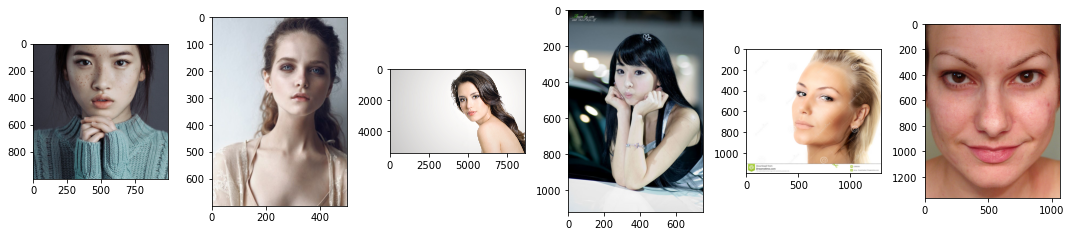

In [220]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["figure.autolayout"] = True
for i in range(6):
    plt.subplot(1, 6, i + 1)
    img = Image.open(female_dir + '/' + female_file_names[i])
    plt.imshow(img)
plt.show()


Here's the first 6 images of the **/male** directory.

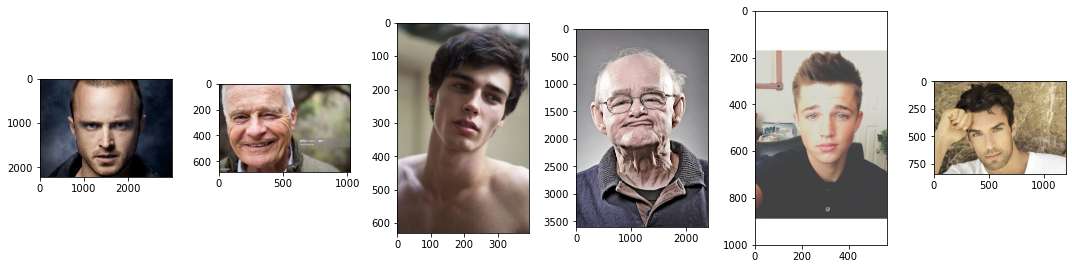

In [5]:
for i in range(6):
    plt.subplot(1, 6, i + 1)
    img = Image.open(male_dir + '/' + male_file_names[i])
    plt.imshow(img)
plt.show()

**Note that the dimensions of each image are all different.**

This will cause issues when we try to input them into our neural network. In the next section, we will go over about how we approach standardizing the image dimensions so that they can be used as input for our neural network. 

## Image Preprocessing

In the last section, we found that the images were all of different dimensions. Our goal in this section will be to set all the dimension of each image to the same size and convert the image objects to tensors that can be read by our neural network.

In [242]:
image_data = []
image_size = 224
for image_name in female_file_names:
    # turn jpeg into tensor
    image = tf.image.decode_jpeg(tf.io.read_file(female_dir + '/' + image_name), channels = 3)
    # resize and crop with padding to 255 black where its padded
    image = tf.cast(tf.image.resize_with_pad(image,image_size,image_size),dtype = tf.uint8)
    # add to data
    image_data.append(image)

for image_name in male_file_names:
    image = tf.image.decode_jpeg(tf.io.read_file(male_dir + '/' + image_name), channels = 3)
    image = tf.cast(tf.image.resize_with_pad(image,image_size,image_size),dtype = tf.uint8)
    image_data.append(image)


We can use same the code from above to plot the images. Let's see the results of out the image transformations.

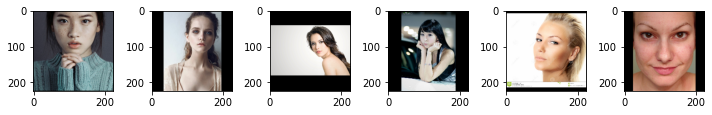

In [246]:

for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(image_data[i])
plt.show()

As you can see, all the images are now the same size tensors with dimensions 224 x 224 x 3. Note how the tensors have 3 dimensions. This is because we set *channels = 3* inside of the *tf.image.decode_jpeg()* function. This causes the image to be split by RGB values. Let's plot each of RGB matrices respectively for the first image.

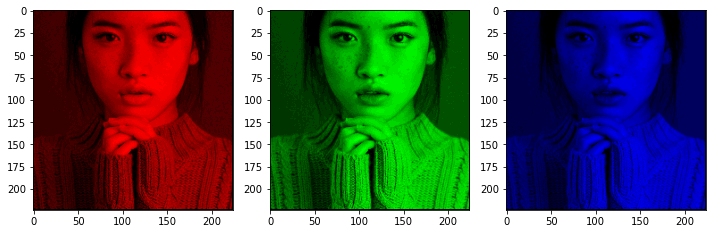

In [262]:
from matplotlib.colors import LinearSegmentedColormap
r = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
g = [(0, 0, 0), (0, 1, 0)]
b = [(0, 0, 0), (0, 0, 1)]
colors= [r, g, b]

for i in range(3):
    cm= LinearSegmentedColormap.from_list(
        "Custom", colors[i], N=20)
    plt.subplot(1, 3, i+1)
    plt.imshow(image_data[0][:, :, i], cmap=cm)
plt.show()

Now our image data has been transformad to a 3-dimensional tensor. In short, 3 of the these 2-dimensional matrices (RGB) are stacked on top of each other which creates an RGB image.

Now our raw images have been processed and are ready to be input into a neural network.

## Create Train and Validation Set

Before we create our mdoel, we will first partition our data into a training and test set. The *scikit-learn* package contains a useful function called *train_test_split()* that we can use to easily partition our data.

The code below will partition our entire data set of 800 classified observations into our training and test set. We will randomly set aside 0.2 of our data to use for testing, and the rest will be used for training. 

In [27]:
from sklearn.model_selection import train_test_split

images_np = np.array(image_data)

labels = np.array([0] * len(female_file_names) + [1] * len(male_file_names))
labels_np = np.array(labels)

images_train, images_test, labels_train, labels_test = train_test_split(images_np, labels_np, test_size = 0.2, random_state=1)

images_train = tf.convert_to_tensor(images_train)
images_test = tf.convert_to_tensor(images_test)
labels_train = tf.convert_to_tensor(labels_train, dtype_hint=tf.uint8)
labels_test = tf.convert_to_tensor(labels_test, dtype_hint=tf.uint8)

It is important to note that you must specify the data type of your tensors in the *d'type_hint ='* parameter when converting your list of labels to a tensor. Not specifying data types may lead to errors when training and evaluating your neural network.

## Deep Convolutional Neural Network

Now that our data is ready, let's create our model! Our model architecture is inspired by the AlexNet Deep Convolutional Neural Network. The AlexNet CNN features 8-layers with 5 convolutional layers and 3 dense layers. To read more about this model refer to *Section 3.5: Overall Architecture* in the research paper linked below. That section will cover the kernals, kernal sizes, pooling layers, normalization layers, activation functions, dense layer nodes, dropout, and activation functions. 

One limitation that we must be accounted for was the massize number of the parameters the AlexNet CNN has. ***It has 60 million.*** In 2010, when this model was trained on 2 GPUs, it took 6 days.

As noted, we take inspiration from this model and use the same layer pipeline; however, we reduce the number of filters in each convolutional layer and the number of nodes in the dense layers. This reduces the number of parameters from 60 million to ~2 million. This number is more workable for the purposes of this demonstration.

https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf


In [311]:
from keras import layers

model = keras.Sequential(
    [
        # 1st Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', padding='same', input_shape=(224, 224, 3)),
        # Max-Pooling
        layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        # Batch Normalization
        layers.BatchNormalization(),

        # 2nd Convolutional Layer
        layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same'),
        # Max-Pooling
        layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        # Batch Normalization
        layers.BatchNormalization(),

        # 3nd Convolutional Layer
        layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),

        # 4th Convolutional Layer
        layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),

        # 5th Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),

        # Flattening
        layers.Flatten(),

        # 1st Dense Layer
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        # 2nd Dense Layer
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        # 3rd Dense (Output) Layer
        layers.Dense(2, activation='softmax'),
    ]
)

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 56, 56, 32)        11648     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_76 (Conv2D)          (None, 28, 28, 64)        51264     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                     

Now that we have created our CNN, let's compile it with the adam optimizer.

In [312]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

To train our model, we use the *.fit()* method and input our training data that we partitioned. We'll run it for 40 epochs and assign our test data to *'validation_data'=* so that we can measure the test accuracy of our model.

In [313]:
hist = model.fit(x = images_train,
                 y = labels_train,
                 epochs=40, 
                 validation_data=(images_test, labels_test), 
                 shuffle = True)

Epoch 1/40
20/20 [==============================] - 5s 88ms/step - loss: 0.7307 - accuracy: 0.5500 - val_loss: 0.6456 - val_accuracy: 0.6375
Epoch 2/40
20/20 [==============================] - 1s 53ms/step - loss: 0.6788 - accuracy: 0.6047 - val_loss: 0.6482 - val_accuracy: 0.6813
Epoch 3/40
20/20 [==============================] - 1s 34ms/step - loss: 0.6377 - accuracy: 0.6188 - val_loss: 0.6377 - val_accuracy: 0.6562
Epoch 4/40
20/20 [==============================] - 1s 33ms/step - loss: 0.6297 - accuracy: 0.6578 - val_loss: 0.6861 - val_accuracy: 0.5688
Epoch 5/40
20/20 [==============================] - 1s 32ms/step - loss: 0.6199 - accuracy: 0.6438 - val_loss: 0.6494 - val_accuracy: 0.5813
Epoch 6/40
20/20 [==============================] - 1s 32ms/step - loss: 0.5670 - accuracy: 0.6984 - val_loss: 0.6357 - val_accuracy: 0.6500
Epoch 7/40
20/20 [==============================] - 1s 32ms/step - loss: 0.5334 - accuracy: 0.7281 - val_loss: 0.6116 - val_accuracy: 0.6375
Epoch 8/40
20

Now that we have trained the model we can plot the history of model to show the Test Loss and Test Accuracy over the 40 epochs it was trained over.

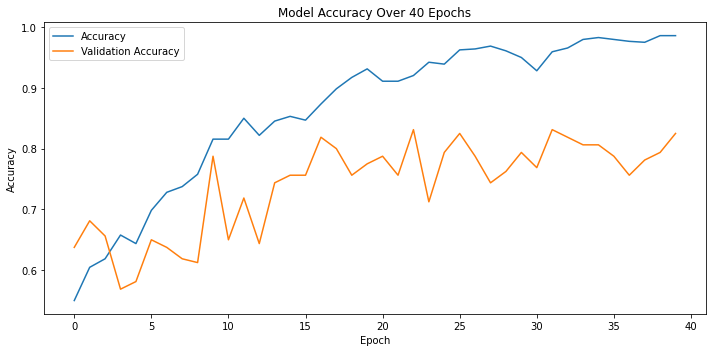

In [317]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy Over 40 Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

In [314]:
test_scores = model.evaluate(y = labels_test, 
                             x = images_test, 
                             verbose=2)
                             
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

5/5 - 0s - loss: 0.9366 - accuracy: 0.8250 - 323ms/epoch - 65ms/step
Test loss: 0.9365582466125488
Test accuracy: 0.824999988079071


In [327]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in model.layers],
)


plt.rcParams["figure.figsize"] = [10, 20]
plt.rcParams["figure.autolayout"] = False

features = feature_extractor()

for i in range(9):
    print(i, 'th layer')
    feature = features[i]
    for j in range(len(feature[0, 0, 0])):
        plt.subplot(16, 8,  j+1)
        plt.imshow(feature[0, :, :, j])
        plt.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


ValueError: Layer "model_173" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>]

In [339]:
tf.constant(np.array(images_train[0]))

<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>